In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import scipy.io.wavfile as wavfile
import os
import warnings
import pickle
import time
# import functionality from MFCC
import gmmhmm as hmm
import MFCC

warnings.filterwarnings('ignore')

## Problem 1

Write a function which accepts a GMMHMM as well as
an integer n_sim, and which simulates the GMMHMM process, generating n_sim different
observations. Use the example GMMHMM to sample 900 times. Use PCA from SkLearn to plot your generated observations in 2D space. Color observations by state.

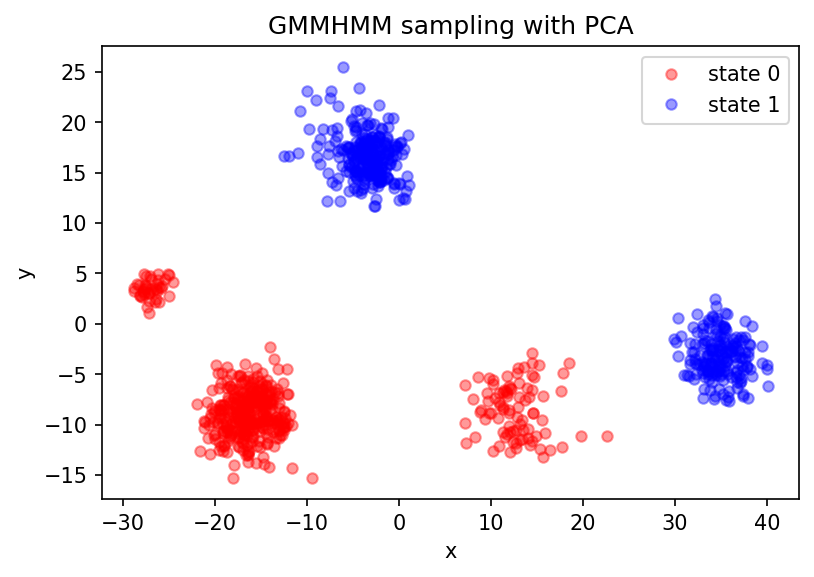

In [3]:
def sample_gmmhmm(gmmhmm, n_sim):
    """
    Simulate from a GMMHMM.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    
    # initialize variables
    A, weights, means, covars, π = gmmhmm
    states = np.zeros(n_sim).astype(int)
    # chose initial state
    states[0] = np.argmax(np.random.multinomial(1, π))
    # choose initial sample
    sample_component = np.argmax(np.random.multinomial(1, weights[states[0],:]))
    obs = np.random.multivariate_normal(means[states[0], sample_component, :],
                                        covars[states[0], sample_component, :, :])
    
    for i in range(1, n_sim):
        # get new state
        states[i] = np.argmax(np.random.multinomial(1, A[:, states[i-1]]))
        # get new samples
        sample_component = np.argmax(np.random.multinomial(1, weights[states[i],:]))
        new_obs = np.random.multivariate_normal(means[states[i], sample_component, :],
                                                covars[states[i], sample_component, :, :])
        
        obs = np.vstack((obs, new_obs))
        
    return states, obs

def problem1():
    A = np.array([[.65, .35], [.15, .85]]) # state transition matrix
    pi = np.array([.8, .2]) # initial state distribution
    weights = np.array([[.7, .2, .1], [.1, .5, .4]])
    means1 = np.array([[0., 17., -4.], [5., -12., -8.], [-16., 22., 2.]])
    means2 = np.array([[-5., 3., 23.], [-12., -2., 14.], [15., -32., 0.]])
    means = np.array([means1, means2])
    covars1 = np.array([5*np.eye(3), 7*np.eye(3), np.eye(3)])
    covars2 = np.array([10*np.eye(3), 3*np.eye(3), 4*np.eye(3)])
    covars = np.array([covars1, covars2])
    gmmhmm = [A, weights, means, covars, pi]
    
    # sample
    states, obs = sample_gmmhmm(gmmhmm, 900)
    
    # perform PCA
    pca = PCA( n_components=2 )
    obs = pca.fit_transform(obs)
    mask0 = states == 0
    mask1 = states == 1
    obs0 = obs[mask0]
    obs1 = obs[mask1]
    # plot with color
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(obs0[:, 0], obs0[:, 1], 'ro', alpha=0.4, markersize=5, label='state 0')
    ax.plot(obs1[:, 0], obs1[:, 1], 'bo', alpha=0.4, markersize=5, label='state 1')
    ax.set_title('GMMHMM sampling with PCA')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')
    plt.show()
    
    return
problem1()

It looks like there are 5 clusters

## Problem 2

Samples.zip contains 30 recordings for each of the words/phrases mathematics, biology, political science, psychology, and statistics. These audio samples are 2 seconds in
duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed
integers in WAV format. 
Load the recordings into Python using scipy.io.wavfile.read

Extract the MFCCs from each sample using code from the file MFCC.py.
Store the MFCCs for each word in a separate list. You should have five lists, each containing
30 MFCC arrays, corresponding to each of the five words under consideration.

(198, 10)


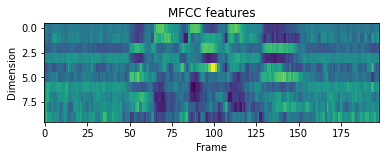

In [9]:
def extract_coefficients():
    
    # intialize lists containing math files
    math_files= []
    bio_files = []
    polysci_files = []
    psych_files = []
    stats_files = []
    
    # iterate through the files and add all files to the appropriate list
    for directory, subdirectories, files in os.walk('.'):
        for filename in files:
            if filename.endswith(".wav"):
                if "(" not in filename:
                    continue
                if "Mathematics" in filename:
                    math_files.append(os.path.join(directory[2:], filename))
                elif "Biology" in filename:
                    bio_files.append(os.path.join(directory[2:], filename))
                elif "PoliticalScience" in filename:
                    polysci_files.append(os.path.join(directory[2:], filename))
                elif "Psychology" in filename:
                    psych_files.append(os.path.join(directory[2:], filename))
                elif "Statistics" in filename:
                    stats_files.append(os.path.join(directory[2:], filename))
                    
          
    # make sure all files are accounted for
    assert len(math_files) == 30
    assert len(bio_files) == 30
    assert len(polysci_files) == 30
    assert len(psych_files) == 30
    assert len(stats_files) == 30
                
    # initalize lists holding the MFCCs
    math_mfccs = []
    bio_mfccs = []
    polysci_mfccs = []
    psych_mfccs = []
    stats_mfccs = []
    
    # populate lists
    for mf, bf, pof, psf, sf in zip(math_files, bio_files, polysci_files, psych_files, stats_files):
        
        math_mfccs.append(MFCC.extract(wavfile.read(mf)[1]))
        bio_mfccs.append(MFCC.extract(wavfile.read(bf)[1]))
        polysci_mfccs.append(MFCC.extract(wavfile.read(pof)[1]))
        psych_mfccs.append(MFCC.extract(wavfile.read(psf)[1]))
        stats_mfccs.append(MFCC.extract(wavfile.read(sf)[1]))
        
    return math_mfccs, bio_mfccs, polysci_mfccs, psych_mfccs, stats_mfccs
print(extract_coefficients()[0][0].shape)

## Problem 3

Partition each list of MFCCs into a training set of 20 samples, and a test set of
the remaining 10 samples.
Using the training sets, train a GMMHMM on each of the words from the previous problem
with at least 10 random restarts, keeping the best model for each word (the one with the highest
log-likelihood). This process may take several minutes. Since you will not want to run this
more than once, you will want to save the best model for each word to disk using the pickle
module so that you can use it later.

In [4]:
def initialize(n_states):
    transmat = np.ones((n_states,n_states))/float(n_states)
    for i in range(n_states):
        transmat[i,:] += sp.random.uniform(-1./n_states,1./n_states,n_states)
        transmat[i,:] /= sum(transmat[i,:])
    startprob = np.ones(n_states)/float(n_states) + sp.random.uniform(-1./n_states,1./n_states,n_states)
    startprob /= sum(startprob)
    return startprob, transmat

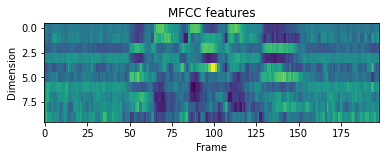

In [5]:
def partition():
    """
    Partitions into train and test states
    """
    
    # extract coefficeints
    math_mfccs, bio_mfccs, poly_mfccs, psych_mfccs, stats_mfccs = extract_coefficients()
    
    # now we partition into train and test sets
    _train_ind = set(np.random.choice(np.arange(30).astype(int), size=20, replace=False))
    _test_ind = set(np.arange(30).astype(int)).difference(_train_ind)
            
    # split into train and test cases
    math_train = []
    bio_train = []
    poly_train = []
    psych_train = []
    stats_train = []
    for i in _train_ind:
        math_train.append(math_mfccs[i])
        bio_train.append(bio_mfccs[i])
        poly_train.append(poly_mfccs[i])
        psych_train.append(psych_mfccs[i])
        stats_train.append(stats_mfccs[i])
    
    math_test = []
    bio_test= []
    poly_test = []
    psych_test = []
    stats_test = []
    for i in _test_ind:
        math_test.append(math_mfccs[i])
        bio_test.append(bio_mfccs[i])
        poly_test.append(poly_mfccs[i])
        psych_test.append(psych_mfccs[i])
        stats_test.append(stats_mfccs[i])     
    
    math = [math_train, math_test]
    bio = [bio_train, bio_test]
    poly = [poly_train, poly_test]
    psych = [psych_train, psych_test]
    stats = [stats_train, stats_test]
    
    return math, bio, poly, psych, stats

def find_best_model():
    
    math, bio, poly, psych, stats = partition()

    # save train and test sets to .npy files
    np.save('math_train.npy', np.array(math[0]))
    np.save('math_test.npy', np.array(math[1]))
    np.save('bio_train.npy', np.array(bio[0]))
    np.save('bio_test.npy', np.array(bio[1]))
    np.save('poly_train.npy', np.array(poly[0]))
    np.save('poly_test.npy', np.array(poly[1]))
    np.save('psych_train.npy', np.array(psych[0]))
    np.save('psych_test.npy', np.array(psych[1]))
    np.save('stats_train.npy', np.array(stats[0]))
    np.save('stats_test.npy', np.array(stats[1]))
    
    
    max_math = -np.inf
    max_bio = -np.inf
    max_poly = -np.inf
    max_psych = -np.inf
    max_stats = -np.inf
    for _ in range(10):
        # find best math model
        startprob, transmat = initialize(5)
        model = hmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, 
                           startprob=startprob, cvtype='diag')
        model.covars_prior = 0.01
        model.fit(math[0], init_params='mc', var=0.1)
        if model.logprob > max_math:
            with open('best_math_model.obj', 'wb') as of:
                pickle.dump(model, of)
                max_math = model.logprob
        
        # find best bio model
        startprob, transmat = initialize(5)
        model = hmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, 
                           startprob=startprob, cvtype='diag')
        model.covars_prior = 0.01
        model.fit(bio[0], init_params='mc', var=0.1)
        if model.logprob > max_bio:
            with open('best_bio_model.obj', 'wb') as of:
                pickle.dump(model, of)
                max_bio = model.logprob
                
        # find best poly model
        startprob, transmat = initialize(5)
        model = hmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, 
                           startprob=startprob, cvtype='diag')
        model.covars_prior = 0.01
        model.fit(poly[0], init_params='mc', var=0.1)
        if model.logprob > max_poly:
            with open('best_poly_model.obj', 'wb') as of:
                pickle.dump(model, of)
                max_poly = model.logprob            

        # find best psych model
        startprob, transmat = initialize(5)
        model = hmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, 
                           startprob=startprob, cvtype='diag')
        model.covars_prior = 0.01
        model.fit(psych[0], init_params='mc', var=0.1)
        if model.logprob > max_psych:
            with open('best_psych_model.obj', 'wb') as of:
                pickle.dump(model, of)
                max_psych = model.logprob   

        # find best stats model
        startprob, transmat = initialize(5)
        model = hmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, 
                           startprob=startprob, cvtype='diag')
        model.covars_prior = 0.01
        model.fit(stats[0], init_params='mc', var=0.1)
        if model.logprob > max_stats:
            with open('best_stats_model.obj', 'wb') as of:
                pickle.dump(model, of)
                max_stats= model.logprob   
                
    return 
start = time.time()
find_best_model()
end = time.time()

## Problem 4

Classify the 10 test samples for each word. Make a dictionary containing the accuracy
of the classification of your five testing sets where the words/phrases are the keys,
and the values are the percent accuracy.

Write a few sentences answering the following questions:
How does your system perform?
Which words are the hardest to correctly classify?

In [12]:
def classification():
    
    # initialize dictionary
    accuracies = {'mathematics' : 0, 
                 'biology' : 0, 
                 'political science' : 0, 
                 'psychology' : 0, 
                 'statistics' : 0
                 }
    
    # restore testing MFCCs
    math_test = np.load('math_test.npy')
    bio_test = np.load('bio_test.npy')
    poly_test = np.load('poly_test.npy')
    psych_test = np.load('psych_test.npy')
    stats_test = np.load('stats_test.npy')
    
    # restore the best models
    with open('best_math_model.obj', 'rb') as of:
        math_model = pickle.load(of)
        
    with open('best_bio_model.obj', 'rb') as of:
        bio_model = pickle.load(of)
        
    with open('best_poly_model.obj', 'rb') as of:
        poly_model = pickle.load(of)
        
    with open('best_psych_model.obj', 'rb') as of:
        psych_model = pickle.load(of)
        
    with open('best_stats_model.obj', 'rb') as of:
        stats_model = pickle.load(of)
        
    # now we score the models
    all_models = [math_model, 
                  bio_model, 
                  poly_model, 
                  psych_model, 
                  stats_model]
    
    for math, bio, poly, psych, stats in zip(math_test, bio_test, poly_test, psych_test, stats_test):
        
        classify_math = [model.score(math) for model in all_models]
        
        if np.argmax(classify_math) == 0:
            accuracies['mathematics'] += 1
            
        classify_bio = [model.score(bio) for model in all_models]
        
        if np.argmax(classify_bio) == 1:
            accuracies['biology'] += 1
    
        classify_poly = [model.score(poly) for model in all_models]
        
        if np.argmax(classify_poly) == 2:
            accuracies['political science'] += 1
        
        classify_psych = [model.score(psych) for model in all_models]
        
        if np.argmax(classify_psych) == 3:
            accuracies['psychology'] += 1
        
        classify_stats = [model.score(stats) for model in all_models]
        
        if np.argmax(classify_stats) == 4:
            accuracies['statistics'] += 1
        
    accuracies = { key : accuracies[key] / 10 for key in list(accuracies.keys())}
        
    return accuracies

scores = classification()

for key in list(scores.keys()):
    print('Word:', key, "\nScore:", scores[key], '\n')
    

Word: mathematics 
Score: 1.0 

Word: biology 
Score: 0.8 

Word: political science 
Score: 0.9 

Word: psychology 
Score: 1.0 

Word: statistics 
Score: 1.0 



This actually preforms pretty well, it looks like the two hardest words to classify were biology with 80% acdcuracy and political science with 90% accuracy. Every other word had 100% accuracy. 